# core

> A few core functionalities to work with data representing bill of materials

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
#| export
def get_sample_data():
    """
    Return sample BOM data (df) and item attributes (df_attributes)
    for demonstration purposes.
    """
    import pandas as pd
    
    data = [
        # Rotary Vane Pump (Oil-lubricated) - PUMP_RV1
        ['PUMP_RV1', 'MOTOR_A1', 1],
        ['PUMP_RV1', 'CASE_STD1', 1],
        ['PUMP_RV1', 'VANE_ASM1', 1],
        ['PUMP_RV1', 'OIL_SYSTEM1', 1],
        ['VANE_ASM1', 'VANE_001', 6],
        ['VANE_ASM1', 'BEARING_01', 2],

        # Rotary Vane Pump (Dry-running) - PUMP_RV2
        ['PUMP_RV2', 'MOTOR_A1', 1],
        ['PUMP_RV2', 'CASE_STD1', 1],
        ['PUMP_RV2', 'VANE_ASM2', 1],
        ['VANE_ASM2', 'VANE_002', 6],
        ['VANE_ASM2', 'BEARING_01', 2],

        # Screw Pump - PUMP_SC1
        ['PUMP_SC1', 'MOTOR_B1', 1],
        ['PUMP_SC1', 'CASE_SC1', 1],
        ['PUMP_SC1', 'SCREW_ASM1', 1],
        ['SCREW_ASM1', 'SCREW_001', 2],
        ['SCREW_ASM1', 'BEARING_02', 4],

        # Claw Pump - PUMP_CL1
        ['PUMP_CL1', 'MOTOR_A1', 1],
        ['PUMP_CL1', 'CASE_CL1', 1],
        ['PUMP_CL1', 'CLAW_ASM1', 1],
        ['CLAW_ASM1', 'CLAW_001', 2],
        ['CLAW_ASM1', 'BEARING_02', 4],
    ]
    df = pd.DataFrame(data, columns=['predecessor', 'successor', 'quantity'])

    attributes_data = {
        'id': [
            'PUMP_RV1', 'PUMP_RV2', 'PUMP_SC1', 'PUMP_CL1',
            'MOTOR_A1', 'MOTOR_B1',
            'CASE_STD1', 'CASE_SC1', 'CASE_CL1',
            'VANE_ASM1', 'VANE_ASM2', 'SCREW_ASM1', 'CLAW_ASM1',
            'VANE_001', 'VANE_002', 'SCREW_001', 'CLAW_001',
            'BEARING_01', 'BEARING_02',
            'OIL_SYSTEM1'
        ],
        'component_type': [
            'assembly', 'assembly', 'assembly', 'assembly',
            'motor', 'motor',
            'case', 'case', 'case',
            'subassembly', 'subassembly', 'subassembly', 'subassembly',
            'vane', 'vane', 'screw', 'claw',
            'bearing', 'bearing',
            'lubrication'
        ],
        'material': [
            'mixed', 'mixed', 'mixed', 'mixed',
            'steel/copper', 'steel/copper',
            'cast_iron', 'steel', 'aluminum',
            'mixed', 'mixed', 'mixed', 'mixed',
            'ceramic', 'carbon', 'hardened_steel', 'hardened_steel',
            'steel', 'ceramic',
            'mixed'
        ],
        'weight_kg': [
            45.0, 42.0, 55.0, 48.0,
            12.5, 15.0,
            18.0, 22.0, 15.0,
            8.0, 7.5, 12.0, 10.0,
            0.2, 0.15, 2.5, 2.0,
            0.3, 0.25,
            3.5
        ],
        'cost': [
            2500, 2300, 3000, 2800,
            800, 1000,
            400, 600, 450,
            300, 280, 450, 400,
            50, 65, 150, 140,
            30, 45,
            150
        ],
        'supplier_code': [
            'INTERNAL', 'INTERNAL', 'INTERNAL', 'INTERNAL',
            'SUP_A', 'SUP_A',
            'SUP_B', 'SUP_B', 'SUP_C',
            'INTERNAL', 'INTERNAL', 'INTERNAL', 'INTERNAL',
            'SUP_D', 'SUP_D', 'SUP_E', 'SUP_E',
            'SUP_F', 'SUP_F',
            'SUP_G'
        ],
        'procurement_days': [
            0, 0, 0, 0,
            14, 14,
            7, 10, 7,
            0, 0, 0, 0,
            5, 5, 8, 8,
            3, 3,
            5
        ],
        'production_time_min': [
            120, 110, 150, 130,
            0, 0,
            0, 0, 0,
            45, 40, 60, 55,
            0, 0, 0, 0,
            0, 0,
            0
        ]
    }
    df_attributes = pd.DataFrame(attributes_data)

    return df, df_attributes

In [ ]:
df, df_attributes = get_sample_data()

At this point, we have:

- `df` – Bill of Materials table (predecessor, successor, quantity)
- `df_attributes` – Item attributes table (component_type, cost, etc.)

---

## Core Functions

We create one large directed graph containing **all** nodes and edges from `df`. For node attributes, we can optionally merge data from `df_attributes`.

In [ ]:
#| export
def build_complete_graph(df, df_attributes=None):
    """
    Build a directed graph (DiGraph) from the BOM DataFrame.
    Optionally enrich nodes with attributes from df_attributes.
    """
    G = nx.DiGraph()

    # 1. Add edges and nodes based on the BOM
    #    (NetworkX will automatically add the nodes for each edge)
    for _, row in df.iterrows():
        pred = row['predecessor']
        succ = row['successor']
        qty  = row['quantity']
        G.add_edge(pred, succ, quantity=qty)

    # 2. Optionally add node attributes
    if df_attributes is not None:
        # Create dict for quick lookup: {id: { 'component_type': ..., 'cost': ..., ... }}
        attr_dict = df_attributes.set_index('id').to_dict('index')
        for node in G.nodes():
            if node in attr_dict:
                for k, v in attr_dict[node].items():
                    G.nodes[node][k] = v

    return G

In [ ]:
G = build_complete_graph(df, df_attributes)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 20
Number of edges: 21


If we want to see which assemblies or products contain a given part, we can **move upwards** in the graph (following edges backwards).

In [ ]:
#| export
def get_all_predecessors(G, node_id):
    """
    Return a list of all predecessors (ancestors) of `node_id`.
    This effectively finds all assemblies or parent items that contain `node_id`.
    """
    visited = []
    queue = [node_id]
    while queue:
        current = queue.pop(0)
        for p in G.predecessors(current):
            if p not in visited:
                visited.append(p)
                queue.append(p)
    return visited

Now, we can answer questions like:
> Where is component 'MOTOR_A1' installed?

In [ ]:
get_all_predecessors(G, 'MOTOR_A1')

['PUMP_RV1', 'PUMP_RV2', 'PUMP_CL1']

Similarly, we can move **down** the graph to find all sub-components or child items of a given product or assembly.

In [ ]:
#| export
def get_all_successors(G, node_id):
    """
    Return a list of all successors (descendants) of `node_id`.
    This effectively finds the complete set of parts that make up `node_id`.
    """
    visited = []
    queue = [node_id]
    while queue:
        current = queue.pop(0)
        for s in G.successors(current):
            if s not in visited:
                visited.append(s)
                queue.append(s)
    return visited

Now, we can answer questions like:
> What component are installed in 'PUMP_RV1'?

In [ ]:
get_all_successors(G, 'PUMP_RV1')

['MOTOR_A1', 'CASE_STD1', 'VANE_ASM1', 'OIL_SYSTEM1', 'VANE_001', 'BEARING_01']

We can select a sub_graph by giving a root node and then searching for all successors.

In [ ]:
#| export
def select_subg_by_root(G, root_id):
    nodes_of_interest = get_all_successors(G, root_id)  # or any other list of nodes
    nodes_of_interest.append(root_id)  # don't forget to add the root if needed
    return G.subgraph(nodes_of_interest)

In [ ]:
sub_g = select_subg_by_root(G, 'PUMP_RV1')
sub_g.nodes()

NodeView(('VANE_ASM1', 'VANE_001', 'MOTOR_A1', 'PUMP_RV1', 'OIL_SYSTEM1', 'CASE_STD1', 'BEARING_01'))

For a **multipartite** (hierarchical) layout in NetworkX, each node must have a `level` attribute. The “level” is typically “0” for a root product, “1” for its direct children, “2” for those children’s children, etc. This function automatically detects the root(s) (any node with no incoming edges) and assigns levels by breadth-first search.

In [ ]:
#| export
def get_all_roots(G):
    '''Returns a list of nodes with no ingoing edges (root_nodes)'''
    return [n for n in G.nodes() if G.in_degree(n) == 0]

In [ ]:
#| export
def add_levels(G):
    '''Calculate levels starting from root'''
    roots = get_all_roots(G)
    if len(roots)==1:
        root_id = roots[0]
        levels = {root_id: 0}
        queue = [(root_id, 0)]
        while queue:
            node, level = queue.pop(0)
            for succ in G.successors(node):
                if succ not in levels:
                    levels[succ] = level + 1
                    queue.append((succ, level + 1))
        
        nx.set_node_attributes(G, levels, 'level')
    else:
        print('Has multiple roots or no roots at all!')
    return G

In [ ]:
sub_g = add_levels(sub_g)
[(n[0],n[1]['level']) for n in sub_g.nodes(data=True)]

[('VANE_ASM1', 1),
 ('VANE_001', 2),
 ('MOTOR_A1', 1),
 ('PUMP_RV1', 0),
 ('OIL_SYSTEM1', 1),
 ('CASE_STD1', 1),
 ('BEARING_01', 2)]

The depth of the bill of materials can give us information about the depth of added value per product.

In [ ]:
max([n[1]['level'] for n in sub_g.nodes(data=True)])

2

## Visualizing

Finally, we create a plotting function that can handle:

- Either a **multipartite** layout (if levels are assigned)
- Or a **kamada_kawai** layout (force-directed)

We also display edge attributes (`quantity`), and we allow parameter overrides (font size, node size, color, etc.) for quick styling changes.

In [ ]:
#| export
def plot_graph(G, # NetworkX graph
               layout='multipartite', # 'multipartite' or 'kamada_kawai'
               figsize=(24, 12), 
               font_size=8, 
               node_size=1000, 
               node_color='lightblue', 
               direction='top_to_bottom', # if layout is multipartite the direction is top to bottom, to rotate set to None
               label_rotation=45): #Rotation angle for node labels (in degrees)
    """Plot a graph with specified layout and styling."""
    
    plt.figure(figsize=figsize)
    
    if layout == 'multipartite':
        if 'level' not in G.nodes[list(G.nodes())[0]]: G = add_levels(G)
        pos = nx.multipartite_layout(G, subset_key='level')
        if direction == 'top_to_bottom': pos = {node: (y, -x) for node, (x, y) in pos.items()}
    else: pos = nx.kamada_kawai_layout(G)
    
    nx.draw(G, pos,
            with_labels=False,  # Disable default labels
            font_size=font_size,
            node_size=node_size,
            node_color=node_color)
    
    for node, (x, y) in pos.items():
        plt.text(x, y, s=node, fontsize=font_size, ha='center', va='center', rotation=label_rotation)
    
    edge_labels = nx.get_edge_attributes(G, 'quantity')
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    
    plt.axis('off')
    plt.show()

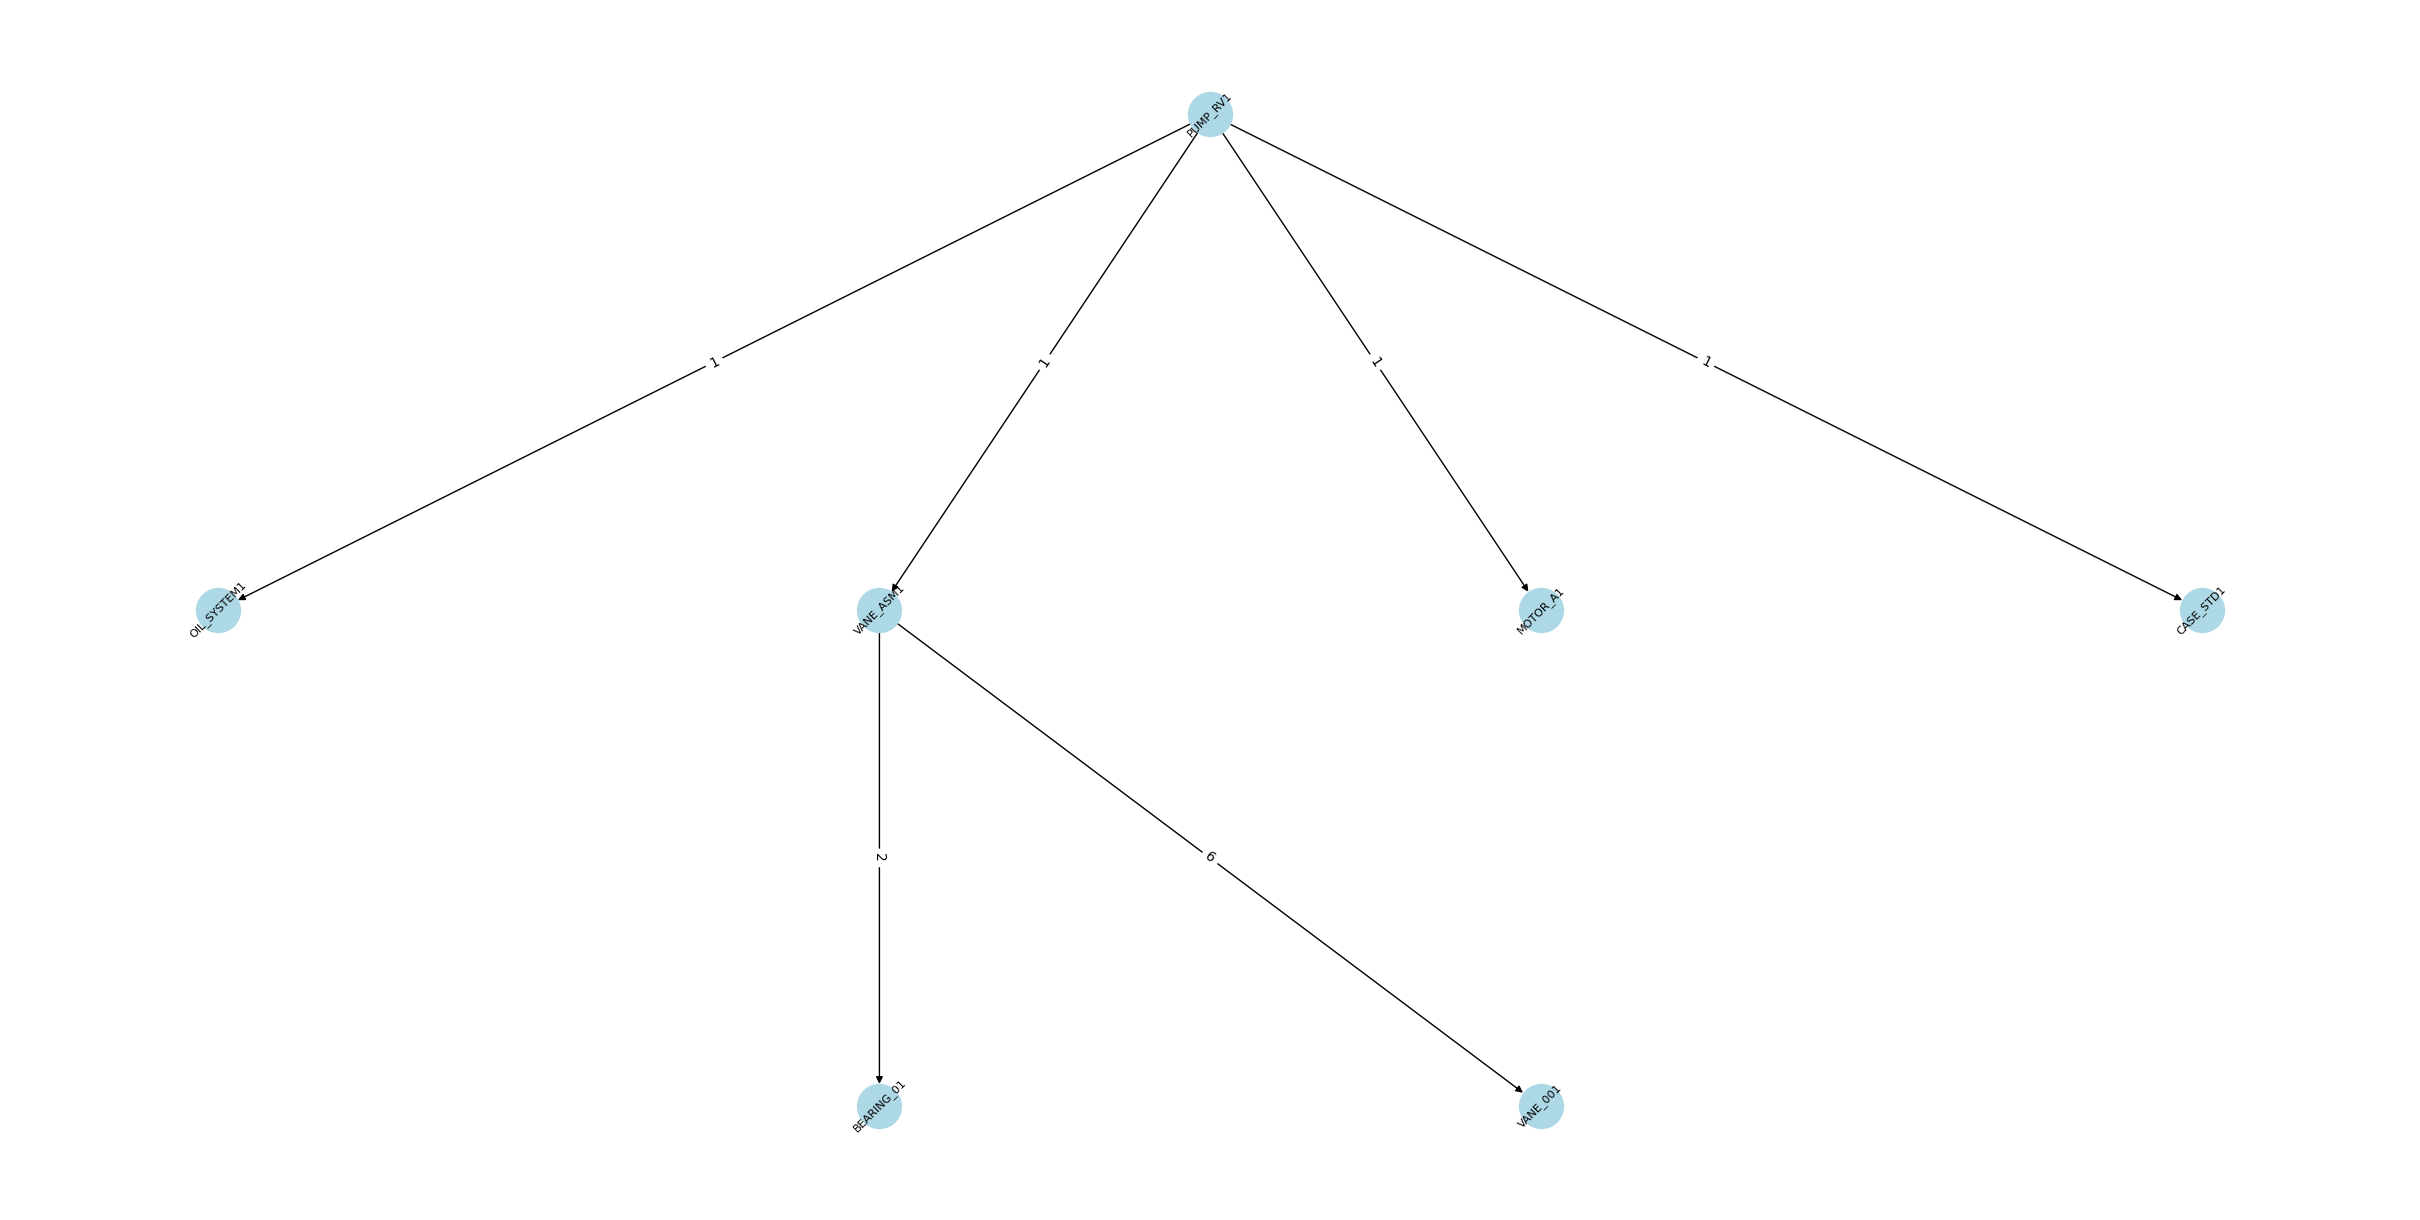

In [ ]:
plot_graph(sub_g)

## Creating a binary matrix

We can also create a binary matrix, with endproducts in the index and parts as columns. This is very helpful, for further analysis, like similarity searches and product clustering.

In [ ]:
#| export
def create_binary_matrix(G, root_nodes=None):
    '''Creates a binary matrix with endproducts as indices and parts as columns'''
    if not root_nodes: 
        root_nodes = get_all_roots(G)
    dfs = [pd.DataFrame({root: get_all_successors(G, root)}).stack() for root in root_nodes]
    final_df = pd.concat(dfs).reset_index(level=-1)
    final_df.columns = ['head', 'parts']
    return final_df.assign(value=1).pivot_table(index='head', columns='parts', values='value', fill_value=0).astype(int)

In [ ]:
b_matrix = create_binary_matrix(G)
b_matrix

  0%|          | 0/4 [00:00<?, ?it/s]

parts,BEARING_01,BEARING_02,CASE_CL1,CASE_SC1,CASE_STD1,CLAW_001,CLAW_ASM1,MOTOR_A1,MOTOR_B1,OIL_SYSTEM1,SCREW_001,SCREW_ASM1,VANE_001,VANE_002,VANE_ASM1,VANE_ASM2
head,,,,,,,,,,,,,,,,
PUMP_CL1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0
PUMP_RV1,1,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0
PUMP_RV2,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1
PUMP_SC1,0,1,0,1,0,0,0,0,1,0,1,1,0,0,0,0


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()